# European Parliament  English Corpus : Topic Modeling 

<a name="top"></a>

## Table of contents : 

-  <a href='#intro'>1. Introduction </a>
        
-  <a href='#lp'>2. Load the packages </a>

-  <a href='#map'>3. Memory allocation problem </a>
 
-  <a href='#ld'>4. Load the Dataset </a>
        
-  <a href='#tok'>5. Tokenization </a>

-  <a href='#rsw'>6. Remove Stop words </a>

-  <a href='#iasl'>7. Idea about Stemming and Lemmatization </a>

-  <a href='#dwm'>8. Create Document-Word matrix by putting all the preprocessing steps together </a>

-  <a href='#fp'>9. Frequencies plot </a>

-  <a href='#smo'>10. Sparsity matrix vector ouptuts </a>

-  <a href='#tmwlda'>11. Topic Modelling with LDA </a>

-  <a href='#em'>12. Evaluation of the Model </a>

-  <a href='#thwg1'>13. Tuning the Hyperparameter with GridSearch : 'n_components': [10,15,20,25,30] </a>

-  <a href='#thwg2'>14. Tuning the Hyperparameter with GridSearch : 'n_components': [3,5,8,10]</a>

-  <a href='#coll'>15. Curve of log-likelihood scores against num_topics</a>

-  <a href='#vwp'>16. Visualization with pyLDAvis </a>

-  <a href='#tg'>17. Topics generation </a>

-  <a href='#wcvt'>18. Word Cloud visualizations of the topics </a>

-  <a href='#wotied'>19. the weights of topics in each document  </a>

-  <a href='#dad'>20. Distribution across documents </a>
    






## <a id='intro'>1. Introduction </a> 

* In this notebook the goal is building a topic modele for European Parliament Corpus dataset, in which we try uncover abstract themes or "topics" based on the underlying documents and words in a corpus of text. 

* This study analyzes by using one of the standard topic modelling techniques here with the first technique known as Latent Dirichlet Allocation (LDA). 


* The outlinez of this notebook is as follows:

    * 1 **Introduction to Latent Dirichlet Allocation Model**
    
    * 2 **Introducing basic text processing methods**
    
    * 3 **Topic Modelling Implementation with LDA**
    





## <a id='lp'>2. Load the packages  </a> 

In [9]:
#def load_packages():
#!pip install spacy
#!pip install pyLDAvis
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import scipy.stats as ss
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
color = sns.color_palette()
sns.set(style="darkgrid")
%matplotlib inline


# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Other imports
import base64
import math
import os 
from collections import Counter
from scipy.misc import imread
import glob
import urllib
from bs4 import BeautifulSoup
import time
from wordcloud import WordCloud, STOPWORDS
#!pip install WordCloud    
import spacy
import re
from nltk.corpus import stopwords


    
#load_packages()

##   <a id='map'>3. Memory allocation problem </a>

* One particular problem that i face durring the implemantation of this project is that my **RAM** is limeted to **8 GB** but the manipulation of the our huge dataset could take more than that. 

* One brutal solution is to download the dataframes on  my "Hard disk drive" and then free the allocation memory.

* I'm using for this task the following  funtion : 


In [10]:
#%reset -s -f
    

## <a id='ld'>4. Load the Dataset </a>


The dataset is about row scrape information from web pages (HTML forme) that contains dives/fragment as <\p> .. <\p> that we should remove. 
One solution to this is use **Beautiful Soup** is a library that makes it easy. It sits atop an HTML or XML parser, providing Pythonic idioms for iterating, searching, and modifying the parse tree.

In [2]:
start_time = time.clock()
##########################################

label = 'en'
path = os.getcwd() + '/' + label + '/'


df = pd.DataFrame()
filenames = list()
filenames.extend(os.listdir(label + '/'))


for file in filenames :
    with open(path + file ,'r', encoding='utf-8') as infile:
        txt = infile.read()
    soup = BeautifulSoup(txt,"lxml")
    text = soup.get_text()
    text = text.replace('\n','')
    df = df.append([text], ignore_index=True)
                       
df.columns = ['text']

##########################################
print(time.clock() - start_time, "seconds")

/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



67.432349 seconds


/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



In [83]:
df.head()
#df.to_csv(r'/Users/soufiane/Downloads/NLP/data.csv')

0    Resumption of the sessionI declare resumed the...
1    Adoption of the Minutes of the previous sittin...
2    Middle East peace process (continuation)The ne...
3    Adoption of the Minutes of the previous sittin...
4    Resumption of the sessionI declare resumed the...
Name: text, dtype: object

In [5]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


## <a href='#tok'>5. Tokenization </a> 


Here the goal is the segregation of the text into its individual constitutent words.

we want to tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.


The concept of tokenization is the act of taking a sequence of characters (think of Python strings) in a given document and dicing it up into its individual constituent pieces, which are the eponymous "tokens" of this method. One could loosely think of them as singular words in a sentence. One could naively implement the "split( )" method on a string which separates it into a python list based on the identifier in the argument. It is actually not that trivial to



#### Testing

In [6]:
#first_text = df.text.values[2900]
test = df.text.values[3]
print(test)
print("="*90)
print("Split the a sentence of the text ")
print("="*90)
print(test.split(" "))
first_text_list = nltk.word_tokenize(test)
print("="*90)
print("After Tokenization")
print("="*90)
print(first_text_list)

Adoption of the Minutes of the previous sittingMr President, I simply wanted to pass on some news. There was a terrorist attack this morning in Madrid. Someone planted a car bomb and one person has died. On behalf of my Group, I once again condemn these terrorist acts.Thank you, Mrs Fraga Estévez. We had heard about this regrettable incident. Unfortunately, the terrorist murderers are once again punishing Spanish society. I note your comments with particular keenness, as you may expect, given that I too am Spanish.(The Minutes were approved)
Split the a sentence of the text 
['Adoption', 'of', 'the', 'Minutes', 'of', 'the', 'previous', 'sittingMr', 'President,', 'I', 'simply', 'wanted', 'to', 'pass', 'on', 'some', 'news.', 'There', 'was', 'a', 'terrorist', 'attack', 'this', 'morning', 'in', 'Madrid.', 'Someone', 'planted', 'a', 'car', 'bomb', 'and', 'one', 'person', 'has', 'died.', 'On', 'behalf', 'of', 'my', 'Group,', 'I', 'once', 'again', 'condemn', 'these', 'terrorist', 'acts.Thank'

## <a id='rsw'>6. Remove Stop words </a> 

Stop words include terms such as "to" or "the" and therefore, it would be to our benefit to remove them during the pre-processing phase. so the goal is to filter out stop words from our tokenized list of words, we can simply use a list comprehension.

In [43]:
stopwords = nltk.corpus.stopwords.words('english')
stop_words = set(stopwords)

print(stop_words)

{'above', 'our', 'y', 'but', "hasn't", "haven't", 'you', 'just', "isn't", 'being', 'myself', 'him', 't', 'on', 'these', 'theirs', 'hadn', 'don', 'm', 'had', 'the', 'wasn', 'or', 'under', 'in', 'and', 'my', 'yourselves', 'isn', 'weren', 'through', 'such', 'not', 'nor', "it's", 'have', 'other', 'some', 'down', 'again', 'before', "mustn't", 'if', 'against', 'about', 'for', 'its', "doesn't", 'same', 'whom', 'into', 'her', 'yourself', "didn't", 'i', 'off', 'your', 'who', 'out', 'during', 'what', 'itself', 'while', 'between', 'hers', 'ain', 'did', "couldn't", 'does', 'was', 's', "shan't", 'she', 'by', 'no', 'after', 'do', 'should', 'those', 'didn', 'doesn', "weren't", 'he', 'once', 'so', 'until', 'both', 'doing', 'most', 'mustn', "needn't", 'when', 'then', 'will', 'am', 'now', 'haven', 'hasn', 'is', 'which', 'has', 'shouldn', "hadn't", "you're", "don't", 'shan', 'too', 'this', 're', 'at', 'any', "aren't", 'needn', 'we', "should've", 'that', 'to', 'how', "you've", 'ours', 'where', 'can', 'him

In [45]:
start_time = time.clock()
##########################################
first_text_list_cleaned = [word for word in first_text_tokenize_.colummn if word.lower() not in stop_words]
print(first_text_list_cleaned[0:20])
print("="*90)
print("Length of original list: {0} words\n"
      "Length of list after stopwords removal: {1} words"
      .format(len(first_text_tokenize), len(first_text_list_cleaned)))

##########################################
print((time.clock() - start_time)/60, "seconds")

['Resumption', 'sessionI', 'declare', 'resumed', 'session', 'European', 'Parliament', 'adjourned', 'Friday', '17', 'December', '1999', ',', 'would', 'like', 'wish', 'happy', 'new', 'year', 'hope']
Length of original list: 59941769 words
Length of list after stopwords removal: 54 words
9.049999999888313e-06 seconds


/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



## <a id='iasl'>7. Idea about Stemming and Lemmatization </a> 

* The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. 
* We can see  stemming and lemmatization as special cases of normalization. They identify a canonical representative for a set of related word forms.

To illustrate these techniques, here are the following examples:

In [47]:
stemmer = nltk.stem.PorterStemmer()
lemm = WordNetLemmatizer()

print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))
print("="*90)x
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))


The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
The stemmed form of leaves is: leav
The lemmatized form of leaves is: leaf


**More about lemmatization** :

For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.


The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

So we are going to use lemmatization for keeping only Noun, Adj, Verb, Adverb.

## <a id='dwm'>8. Create Document-Word matrix by putting all the preprocessing steps together  </a> 

Machine can read in bits and numbers and therefore we will first need to convert our text into numbers for which we utilise a very common approach known as the **Bag-of-Words**, this approach uses the counts of words as a starting block and records the occurrence of each word (from the entire text) in a vector specific to that particular word.


We shall utilize the Scikit-learn library to implement a vectorizer that generates a vector of word counts (term frequencies) - via the **CountVectorizer** method as follows.


**NB :** The Class "**LemmaCountVectorizer**" that we are using here inherited and subclassed the original Sklearn's CountVectorizer class and overwritten the build_analyzer method by implementing the lemmatizer for each list in the raw text matrix.

In [4]:
#%reset

In [11]:
start_time = time.clock()
##########################################
df = pd.read_csv("/Users/soufiane/Downloads/NLP/data.csv")
df = df["text"]
##########################################
print((time.clock() - start_time)/60, "seconds") 

/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



0.07158471666666667 seconds


/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



In [12]:
start_time = time.clock()
##########################################


lemm = WordNetLemmatizer()

class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

    
# Storing the entire training text in a list
text = list(df.values)


# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=5,                 # minimum reqd occurences of a word 
                                     stop_words='english',     # remove stop words
                                     decode_error='ignore',
                                     lowercase=True,            # convert all words to lowercas
                                    )


tf = tf_vectorizer.fit_transform(text)

##########################################
print((time.clock() - start_time)/60, "seconds")

/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



3.18743565 seconds


/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



In [16]:
print("the number of words : " + str(len(tf_vectorizer.get_feature_names())))

the number of words : 32821


## <a id='fp'>9. Frequencies plot  </a> 

In [64]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')


As you can see from the plot, all our prior preprocessing efforts have not gone to waste. With the removal of stopwords, the remaining words seem much more meaningful where you can see that all the stopwords in the earlier term frequency plot


## <a id='smo'>10. Sparsity matrix vector ouptuts  </a> 

Since most cells in this matrix will be zero, we are interested in knowing what percentage of cells contain non-zero values.

The vectorizer returns the transformed raw text as a matrix where most of its values are zero or almost negligible, hence the term sparse, then thinking about checking the sparsity make sense that our returned matrices contain quite a high degree of sparsity due to. 

In [14]:
start_time = time.clock()
##########################################


# Materialize the sparse data
data_dense = tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

##########################################
print((time.clock() - start_time)/60, "seconds")

/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Sparsicity:  1.7668002609537876 %
0.06460348333333314 seconds


/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



##  <a id='tmwlda'>11. Topic Modelling  with LDA   </a> 

Latent Dirichlet Allocation is a generative probabilistic model for collections of discrete dataset such as text corpora. It is also a topic model that is used for discovering abstract topics from a collection of documents.


* The corpus is a collection of $D$ documents.

* A document is a sequence of $N$ words.

* There are $K$ topics in the corpus.

* The boxes represent repeated sampling. 

In the graphical model, each node is a random variable and has a role in the generative process. A shaded node indicates an observed variable and an unshaded node indicates a hidden (latent) variable. In this case, words in the corpus are the only data that we observe. The latent variables determine the random mixture of topics in the corpus and the distribution of words in the documents. The goal of LDA is to use the observed words to infer the hidden topic structure.

When modeling text corpora, the model assumes the following generative process for a corpus with D documents and K topics, with K corresponding to n_components in the API:

* 1. For each topic $k \in K$ , draw $\beta_k \sim Dirichlet(\mu)$. This provides a distribution over the words, i.e. the probability of a word appearing in topic k. $\mu$ corresponds to topic_word_prior.

* 2. For each document $d \in D$, draw the topic proportions $\theta_d \sim Dirichlet(\alpha)$. $\alpha$  corresponds to doc_topic_prior.

* 3. For each word  in document d 

    *  Draw the topic assignment $z_{di} \sim \mathrm{Multinomial}(\theta_d)$
    *  Draw the observed word $w_{ij} \sim \mathrm{Multinomial}(\beta_{z_{di}})$

For parameter estimation, the posterior distribution is:
$$p(z, \theta, \beta |w, \alpha, \eta) = \frac{p(z, \theta, \beta|\alpha, \eta)}{p(w|\alpha, \eta)}$$

In [17]:
start_time = time.clock()
##########################################


# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,            # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                      learning_decay = 0.5
                                     )

lda_output = lda_model.fit_transform(tf)

print(lda_model)  # Model attributes

##########################################
print((time.clock() - start_time)/60, "seconds")

/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)
1.519342566666667 seconds


/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



##   <a id='em'>12. Evaluation of the Model    </a> 
A model with higher log-likelihood and lower perplexity ($\exp(-1. * log-likelihood)$ per word)) is considered to be good. Let’s check for our model.

In [76]:
start_time = time.clock()
##########################################


# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(tf))

##########################################
print((time.clock() - start_time)/60, "seconds")

/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Log Likelihood:  -196136428.4268446
Perplexity:  2407.338528002178
0.08981719999999692 seconds


/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



## <a id='thwg1'>13. Tuning the Hyperparameter with GridSearch : 'n_components': [10, 15, 20, 25, 30] </a> 

The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.


In [77]:
start_time = time.clock()
##########################################


# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

##########################################
print((time.clock() - start_time)/60, "seconds")

/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/Users/soufiane/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



259.89373405 seconds


/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



In [81]:
# Best Model

best_lda_model = model.best_estimator_


# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -66181009.27642528
Model Perplexity:  2358.9290055727124


## <a id='thwg2'>14. Tuning the Hyperparameter with GridSearch : 'n_components': [3,5,8,10] </a> 


In [13]:
start_time = time.clock()
##########################################


# Define Search Param
search_params = {'n_components': [3,5,8,10], 'learning_decay': [.5]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

##########################################
print((time.clock() - start_time)/60, "seconds")

/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/Users/soufiane/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



56.022663216666665 seconds


/Users/soufiane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



In [14]:
# Best Model

best_lda_model = model.best_estimator_


# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -66120833.220062
Model Perplexity:  2413.3976548617356


## <a id='coll'>15. Curve of log-likelihood scores against num_topics</a> 

* we are going to fix the number od topic to : 0.5 
* clearly with the following  plot and the previous Tuning the Hyperparameter with GridSearch : 'n_components': [10, 15, 20, 25, 30] we shows the number of topics = 10 has better scores.

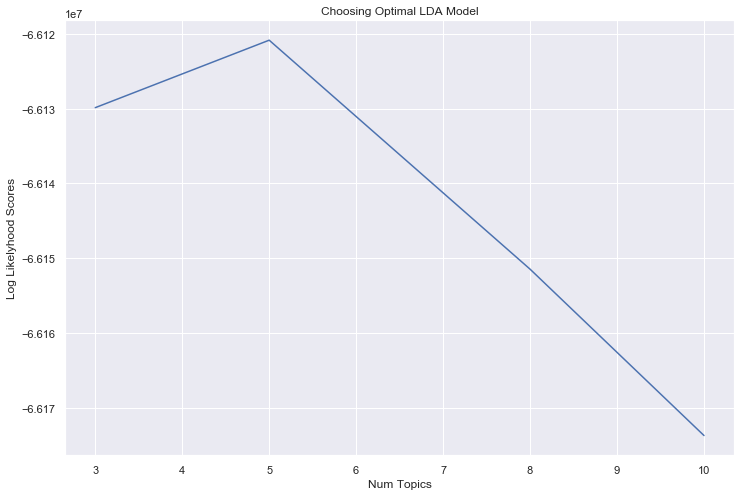

In [52]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [3,5,8,10]
log_likelyhoods_5 = model.cv_results_["mean_test_score"]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")

plt.show()

##  <a id='vwp'>16. Visualization with  pyLDAvis </a> 

The pyLDAvis offers the best visualization to view the topics-keywords distribution.



In [59]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [60]:
#start_time = time.clock()
##########################################


pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, tf, tf_vectorizer, mds='tsne')
#panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

##########################################
#print((time.clock() - start_time)/60, "seconds")

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      247.081070 -128.427597       1        1  27.774944
0        8.546671 -158.862274       2        1  24.449891
1      185.866699  112.704208       3        1  19.080629
4     -199.415176  -38.102531       4        1  16.270904
2      -49.165104  160.174683       5        1  12.423632, topic_info=      Category           Freq        Term          Total  loglift  logprob
11255  Default   36834.000000      energy   36834.000000  30.0000  30.0000
11719  Default  102271.000000          eu  102271.000000  29.0000  29.0000
19047  Default   62840.000000      market   62840.000000  28.0000  28.0000
11786  Default  336207.000000    european  336207.000000  27.0000  27.0000
9715   Default   46155.000000   directive   46155.000000  26.0000  26.0000
30158  Default   22206.000000   transport   22206.000000  25.0000  25.0000
32455  Default   31336.000000       woman   31336.000000  24.0000  24.0000
7805   Default   26975.000000    consumer   26975.000000  23.0000  23.0000
5657   Default   37155.000000      budget   37155.000000  22.0000  22.0000
12738  Default   43485.000000   financial   43485.000000  21.0000  21.0000
3171   Default   57157.000000   amendment   57157.000000  20.0000  20.0000
13481  Default   33243.000000        fund   33243.000000  19.0000  19.0000
10737  Default   63015.000000    economic   63015.000000  18.0000  18.0000
7239   Default  198257.000000  commission  198257.000000  17.0000  17.0000
2823   Default   61350.000000   agreement   61350.000000  16.0000  16.0000
27646  Default   55373.000000      social   55373.000000  15.0000  15.0000
7252   Default   66693.000000   committee   66693.000000  14.0000  14.0000
25247  Default  134802.000000      report  134802.000000  13.0000  13.0000
8344   Default   27152.000000      crisis   27152.000000  12.0000  12.0000
30020  Default   29322.000000       trade   29322.000000  11.0000  11.0000
26672  Default   34304.000000      sector   34304.000000  10.0000  10.0000
6867   Default   13660.000000     climate   13660.000000   9.0000   9.0000
11099  Default    9282.000000    emission    9282.000000   8.0000   8.0000
26191  Default   21556.000000      safety   21556.000000   7.0000   7.0000
23700  Default   77601.000000    proposal   77601.000000   6.0000   6.0000
22910  Default  104464.000000      policy  104464.000000   5.0000   5.0000
20546  Default  109878.000000        need  109878.000000   4.0000   4.0000
28435  Default   26183.000000    strategy   26183.000000   3.0000   3.0000
15287  Default   49731.000000       human   49731.000000   2.0000   2.0000
16094  Default   23710.000000    industry   23710.000000   1.0000   1.0000
...        ...            ...         ...            ...      ...      ...
26868   Topic5   11656.561873     service   37704.501867   0.9117  -5.5928
25848   Topic5    4734.798609        road   10513.700936   1.2878  -6.4937
11719   Topic5   20711.187228          eu  102271.351073   0.4886  -5.0180
29365   Topic5    4950.696424  technology   11445.866908   1.2475  -6.4491
9715    Topic5   11609.723549   directive   46155.890467   0.7054  -5.5968
11786   Topic5   38498.785802    european  336207.800322  -0.0815  -4.3980
8690    Topic5    5269.951314        data   13230.075423   1.1651  -6.3866
26672   Topic5    9136.901532      sector   34304.416374   0.7626  -5.8363
28187   Topic5   22657.598601       state  173997.704054   0.0470  -4.9281
6458    Topic5    8652.888996      change   32768.084028   0.7540  -5.8907
19384   Topic5   20615.950057      member  167569.096113  -0.0098  -5.0226
20546   Topic5   16141.391176        need  109878.606416   0.1676  -5.2672
7239    Topic5   21906.540428  commission  198257.748355  -0.1172  -4.9618
8183    Topic5   17655.228712     country  139815.687957   0.0163  -5.1776
15744   Topic5   13636.602718   important   83257.599296   0.2764  -5.4359
24876   Topic5    8691.874

## <a id='tg'>17. Topics generation  </a> 

In [69]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index )
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1  :-1]])
        print(message)
        print("="*120)
        
n_top_words = 15

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, n_top_words)        
#print_top_words(best_lda_model, tf_feature_names, n_top_words)        


Topic #0:mr commission european member state parliament president report council like proposal committee directive amendment time

Topic #1:mr commission european report president parliament member state policy committee like proposal amendment union year

Topic #2:european energy state commission eu member market mr country agreement need report president important like

Topic #3:european mr president union right country council state europe parliament people member human political like

Topic #4:european state eu member policy report need europe economic union social country commission financial people


## <a id='wcvt'>18. Word Cloud visualizations of the topics  </a> 

Topic 0


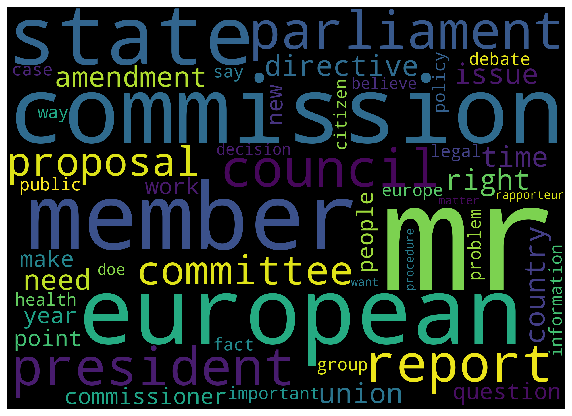

Topic 1


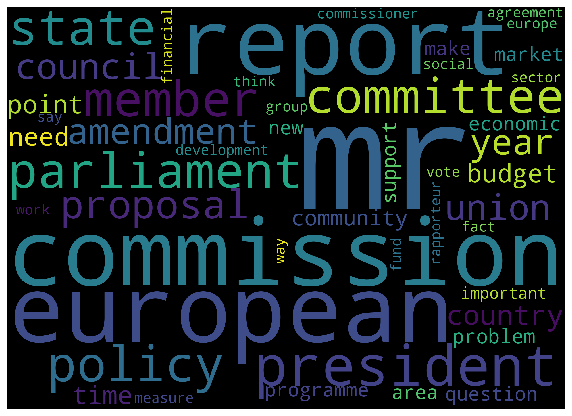

Topic 2


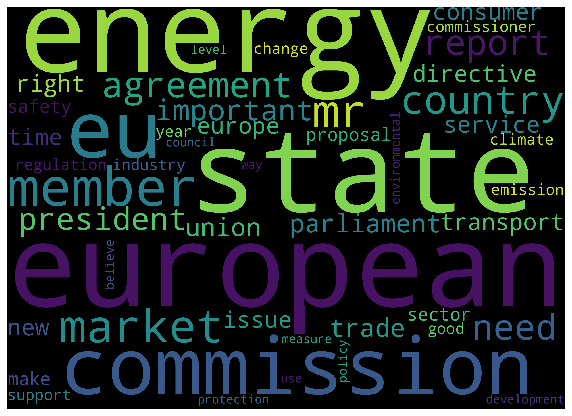

Topic 3


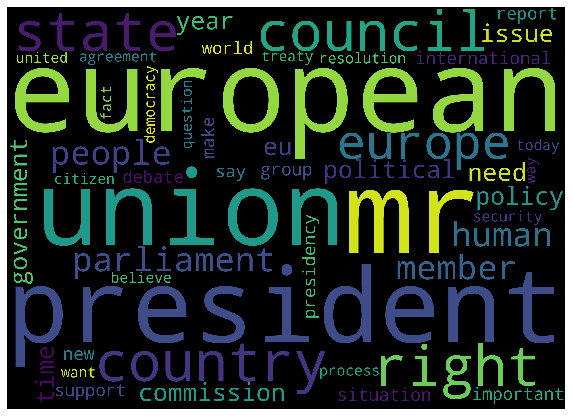

Topic 4


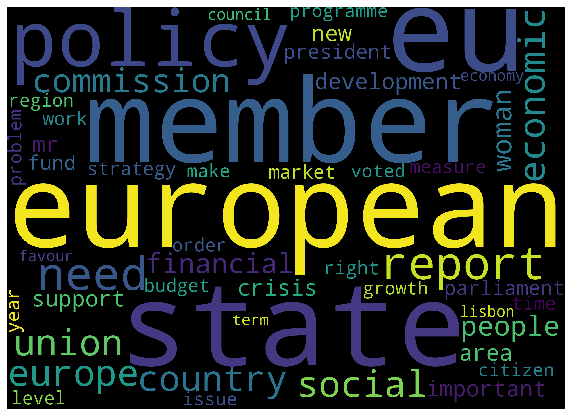

In [70]:
def world_cloud():
    for i in range(model.best_params_["n_components"]):
        topic = best_lda_model.components_[i]
        topic_words = [tf_feature_names[j] for j in topic.argsort()[:-50 - 1 :-1]]
        cloud = WordCloud(stopwords=STOPWORDS,
                       background_color='black',
                       width=2500,
                       height=1800
                     ).generate(" ".join(topic_words))
        print("="*100)
        print("Topic " + str(i))
        print("="*100)
        plt.figure(figsize=(10,10))
        plt.imshow(cloud)
        plt.axis('off')
        plt.show()
        plt.pause(0.05)
        

        

        
world_cloud()        

## <a id='wotied'>19. the weights of  topics in each document   </a> 

In the table below, I’ve greened out all major topics in a document and assigned the most dominant topic in its own column.

In [57]:
data = df.values

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.07,0.8,0,0.01,0.11,1
Doc1,0.43,0.45,0.05,0.05,0.02,1
Doc2,0.18,0.21,0,0.52,0.08,3
Doc3,0,0.32,0,0.67,0,3
Doc4,0.46,0.09,0.03,0.41,0,0
Doc5,0.57,0.03,0.26,0.14,0,0
Doc6,0.03,0.63,0,0.04,0.3,1
Doc7,0.51,0.23,0.01,0.07,0.18,0
Doc8,0.17,0.19,0.01,0.57,0.06,3
Doc9,0.29,0.21,0.04,0.35,0.11,3


## <a id='dad'>20. Distribution across documents  </a> 

In [58]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,4232
1,3,1961
2,0,1203
3,4,1171
4,2,1105


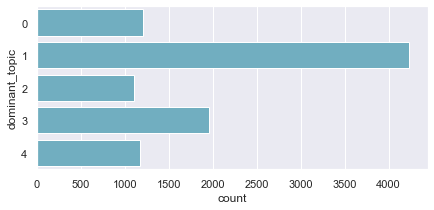

In [62]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="dominant_topic", data = df_document_topic, color="c");